# <font color='blue'>Clustering </font>

**There will be some functions that start with the word "grader" ex: grader_actors(), grader_movies(), grader_cost1() etc, this is for testing. Do not change those function definition.<br><br>Every Grader function has to return True.**

**Please check clustering helper functions notebook before attempting this.**

*  Read graph from the given <font color='blue'>movie_actor_network.csv</font> (note that the graph is bipartite graph.)

*  Using stellergaph and gensim packages, get the dense representation(128dimensional vector) of every node in the graph. 

* Split the dense representation into actor nodes, movies nodes.(in <font color='blue'>def data_split()</font>)


# <font color='red'> 1 : Apply clustering algorithm to group similar actors</font>

 1. Consider only the actor nodes 
 2. Apply any clustering algorithm <br>
    Refer : https://scikit-learn.org/stable/modules/clustering.html
 3. Choose the number of clusters for which we have maximum score of <b>$Cost1*Cost2$</b><br>
 4. Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters 
<br> (code in <font color='blue'>def cost1()</font>)<br>
 5. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 
 <br> (code in <font color='blue'>def cost2()</font>)<br>
 6. Fit the clustering algorithm with the opimal number_of_clusters and get the cluster number for each node <br>
 7. Convert the d-dimensional dense vectors of nodes into 2-dimensional using dimensionality reduction technique TSNE<br>
 8. Plot the 2d scatter plot, with the node vectors after step e and give colors to nodes such that same cluster nodes will have same color

<img src='https://i.imgur.com/4SPYPFa.jpg'>

# <font color='red'> 2 : Apply clustering algorithm to group similar movies</font>


1. Consider only the movie nodes
2. Apply any clustering algorithm 
3.Choose the number of clusters for which we have maximum score of $Cost1*Cost2$ <br>

    Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br>
(Write your code in <font color='blue'>def cost1()</font>)<br>
	
4. Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of movie nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}{\text{(number of unique actor nodes in the graph with the movie nodes and its actor neighbours in cluster i)}}$ 
where N= number of clusters 
<br>(code in <font color='blue'>def cost2()</font>)<br>


**Algorithm for actor nodes**

<pre>
	for number_of_clusters in [3, 5, 10, 30, 50, 100, 200, 500]:
		algo = clustering_algorith(clusters=number_of_clusters)
        # We will be passing a matrix of size N*d where N number of actor nodes and d is dimension from gensim
		algo.fit(the dense vectors of actor nodes) 
        
        We can get the labels for corresponding actor nodes (algo.labels_)
        Create a graph for every cluster(ie., if n_clusters=3, create 3 graphs)
        (We can use ego_graph to create subgraph from the actual graph)
        compute cost1,cost2 
           (if n_cluster=3, cost1=cost1(graph1)+cost1(graph2)+cost1(graph3) # here we are doing summation
            cost2=cost2(graph1)+cost2(graph2)+cost2(graph3)
		computer the metric Cost = Cost1*Cost2
	return number_of_clusters which have maximum Cost
	</pre>

In [1]:
#!pip install networkx==2.3

In [1]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
# we need to have tensorflow 
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph
from operator import itemgetter

from sklearn.manifold import TSNE

In [82]:
data=pd.read_csv('movie_actor_network.csv', index_col=False, names=['movie','actor'])

In [83]:
edges = [tuple(x) for x in data.values.tolist()]

In [84]:
B = nx.Graph()
B.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')
B.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')
B.add_edges_from(edges, label='acted')

In [85]:
A = list(B.subgraph(x) for x in nx.connected_components(B))[0]

In [86]:
print("number of nodes", A.number_of_nodes())
print("number of edges", A.number_of_edges())

number of nodes 4703
number of edges 9650


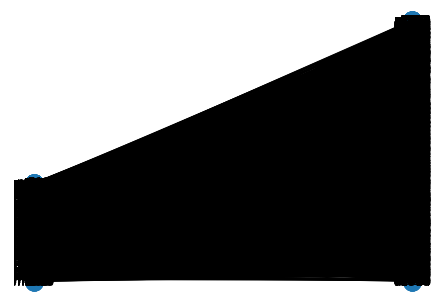

In [87]:
l, r = nx.bipartite.sets(A)
#print(l,r)
pos = {}

pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
  
nx.draw(A, pos=pos, with_labels=True)
plt.show()

In [88]:
movies = []
actors = []
for i in A.nodes():
    if 'm' in i:
        movies.append(i)
    if 'a' in i:
        actors.append(i)
print('number of movies ', len(movies))
print('number of actors ', len(actors))

number of movies  1292
number of actors  3411


In [89]:

# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(A))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
]

walks = rw.run(nodes=list(A.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 4703


In [90]:
from gensim.models import Word2Vec
model = Word2Vec(walks, size=128, window=5)

In [91]:
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(4703, 128)

In [92]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ A.nodes[node_id]['label'] for node_id in node_ids]

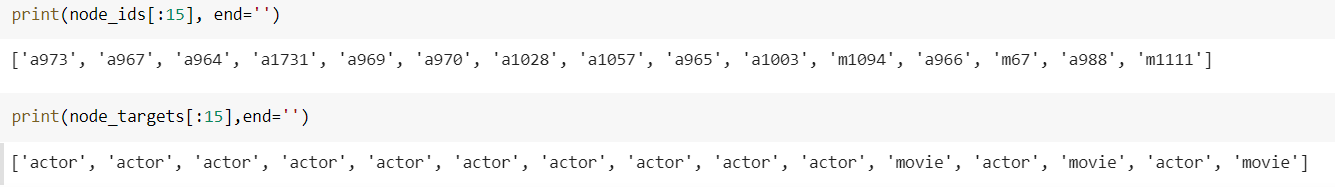

In [93]:
print(node_ids[:10], end="")

['a973', 'a967', 'a964', 'a1731', 'a970', 'a969', 'a965', 'a1028', 'a1057', 'a1003']

In [94]:
print(node_targets[:10], end="")

['actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor']

In [95]:
print(node_embeddings[:10], end="")

[[ 0.7957562   2.097219   -1.1885943  ...  1.2508111  -0.48715302
   0.5515945 ]
 [ 1.4239017   2.132647   -0.9712071  ...  1.6291547   0.3397103
  -0.17296869]
 [ 0.03975858  1.1448992  -2.359496   ...  1.3869283  -0.6127038
   0.42614433]
 ...
 [ 0.28109524  1.2892122  -0.8566372  ...  1.3541185  -0.18687898
  -0.2526427 ]
 [ 0.19652839  0.88638264  0.7123226  ...  1.3803055   0.84201527
  -0.29115647]
 [ 0.09175302  0.49938273 -2.4943092  ... -0.09502137 -0.7615395
   1.0319338 ]]

In [96]:
def data_split(node_ids,node_targets,node_embeddings):
    '''In this function, we will split the node embeddings into actor_embeddings , movie_embeddings '''
    actor_nodes,movie_nodes=[],[]
    actor_embeddings,movie_embeddings=[],[]
    # split the node_embeddings into actor_embeddings,movie_embeddings based on node_ids
    # By using node_embedding and node_targets, we can extract actor_embedding and movie embedding
    # By using node_ids and node_targets, we can extract actor_nodes and movie nodes
    
    for ids, tgt, em in zip(node_ids, node_targets, node_embeddings):
        
        if "a" in tgt and "a" in ids:
            actor_nodes.append(ids)
            actor_embeddings.append(em)
        elif "m" in tgt and "m" in ids:
            movie_nodes.append(ids)
            movie_embeddings.append(em)

    return actor_nodes,movie_nodes,actor_embeddings,movie_embeddings


In [97]:
actor_nodes,movie_nodes,actor_embeddings,movie_embeddings = data_split(node_ids, node_targets, node_embeddings)

In [98]:
np.array(actor_embeddings).shape

(3411, 128)

<font color='cyan'>Graded function - 1</font>

In [99]:
def grader_actors(data):
    assert(len(data)==3411)
    return True
grader_actors(actor_nodes)

True

<font color='cyan'>Graded function - 2</font>

In [100]:
def grader_movies(data):
    assert(len(data)==1292)
    return True
grader_movies(movie_nodes)

True

<font color='blue'>Calculating cost1</font>












































Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br><br>
<br>

In [101]:
def cost1(G, number_of_clusters):
    '''In this function, we will calculate cost1'''
    cost1 = 0
    # identify largest connected component
    for g in range(1, number_of_clusters+1):
        # find node with largest degree
        node_and_degree = G.degree()
        (largest_hub, degree) = sorted(node_and_degree, key=itemgetter(1))[-1]
        # Create ego graph of main hub
        hub_ego = nx.ego_graph(G, largest_hub)
        #print(largest_hub, len(hub_ego.nodes) / len(G.nodes))
        cost1 = len(hub_ego.nodes) / len(G.nodes)
    return cost1/number_of_clusters

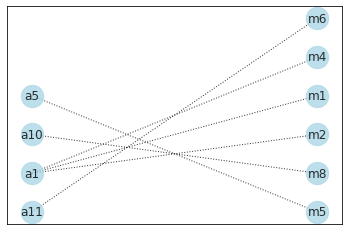

In [102]:
import networkx as nx
from networkx.algorithms import bipartite
graded_graph= nx.Graph()
graded_graph.add_nodes_from(['a1','a5','a10','a11'], bipartite=0) # Add the node attribute "bipartite"
graded_graph.add_nodes_from(['m1','m2','m4','m6','m5','m8'], bipartite=1)
graded_graph.add_edges_from([('a1','m1'),('a1','m2'),('a1','m4'),('a11','m6'),('a5','m5'),('a10','m8')])
l={'a1','a5','a10','a11'};r={'m1','m2','m4','m6','m5','m8'}
pos = {}
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
nx.draw_networkx(graded_graph, pos=pos, with_labels=True,node_color='lightblue',alpha=0.8,style='dotted',node_size=500)

<font color='cyan'>Graded function - 3</font>

In [103]:
graded_cost1=cost1(graded_graph,3)
def grader_cost1(data):
    assert(data==((1/3)*(4/10))) # 1/3 is number of clusters
    return True
grader_cost1(graded_cost1)

True

<font color='blue'>Calculating cost2</font>

Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 

In [104]:
def cost2(G,number_of_clusters):
    '''In this function, we will calculate cost1'''
    cost2 = 0
    
    for g in range(1, number_of_clusters+1):
        movie_nodes = sum([1 for x in G.nodes() if "m" in x])
        #print(G.number_of_edges(), movie_nodes)
        cost2 = G.number_of_edges()/ movie_nodes
    
    return cost2/number_of_clusters

<font color='cyan'>Graded function - 4</font>

In [105]:
graded_cost2=cost2(graded_graph,3)
def grader_cost2(data):
    assert(data==((1/3)*(6/6))) # 1/3 is number of clusters
    return True
grader_cost2(graded_cost2)

True

### 1 : Apply clustering algorithm to group similar actors

In [106]:
def group_actors_movies(clusters, embeddings, nodes):
    
    def get_cost(labels, nodes, n_clusters):
        cluster = [[] for x in range(n_clusters)]

        for l,n in zip(labels, nodes):
            #print(l,n)
            cluster[l].append(n)

        cost1_, cost2_ = 0, 0
        for c in cluster:
            x_, y_, edges = [], [], []
            for x in c:
                for y in list(A[x]):
                    #print(x, y, A.degree(x))
                    x_.append(x)
                    y_.append(y)
                    edges.append((x, y))

            graded_graph= nx.Graph()
            graded_graph.add_nodes_from(x_, bipartite=0) # Add the node attribute "bipartite"
            graded_graph.add_nodes_from(y_, bipartite=1)
            graded_graph.add_edges_from(edges)
            #l=actors; r=movies
            #pos = {}
            #pos.update((node, (1, index)) for index, node in enumerate(l))
            #pos.update((node, (2, index)) for index, node in enumerate(r))
            #nx.draw_networkx(graded_graph, pos=pos, with_labels=True,node_color='lightblue',alpha=0.8,style='dotted',node_size=500)

            cost1_ += cost1(graded_graph, n_clusters)
            cost2_ += cost2(graded_graph, n_clusters)

        #print(cost1_*cost2_)
        return cost1_*cost2_
    
    costs = []
    for cluster in clusters:
        kmeans = KMeans(n_clusters=cluster, random_state=42).fit(embeddings)
        labels = kmeans.labels_
        #print(labels)

        costs.append(get_cost(labels, nodes, cluster))

    #print(costs)
    return clusters[np.argsort(costs)[0]]

In [107]:
clusters = [3, 5, 10, 30, 50, 100, 200, 500]
optimal_cluster = group_actors_movies(clusters, actor_embeddings, actor_nodes)

In [108]:
print(optimal_cluster)

3


<font color='blue'>Grouping similar actors</font>

In [109]:
actor_kmeans = KMeans(n_clusters=optimal_cluster).fit(actor_embeddings)
actor_labels = actor_kmeans.labels_
print(actor_labels)

[2 2 2 ... 0 0 0]


<font color='blue'>Displaying similar actor clusters</font>

In [110]:
transform = TSNE #PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(actor_embeddings)

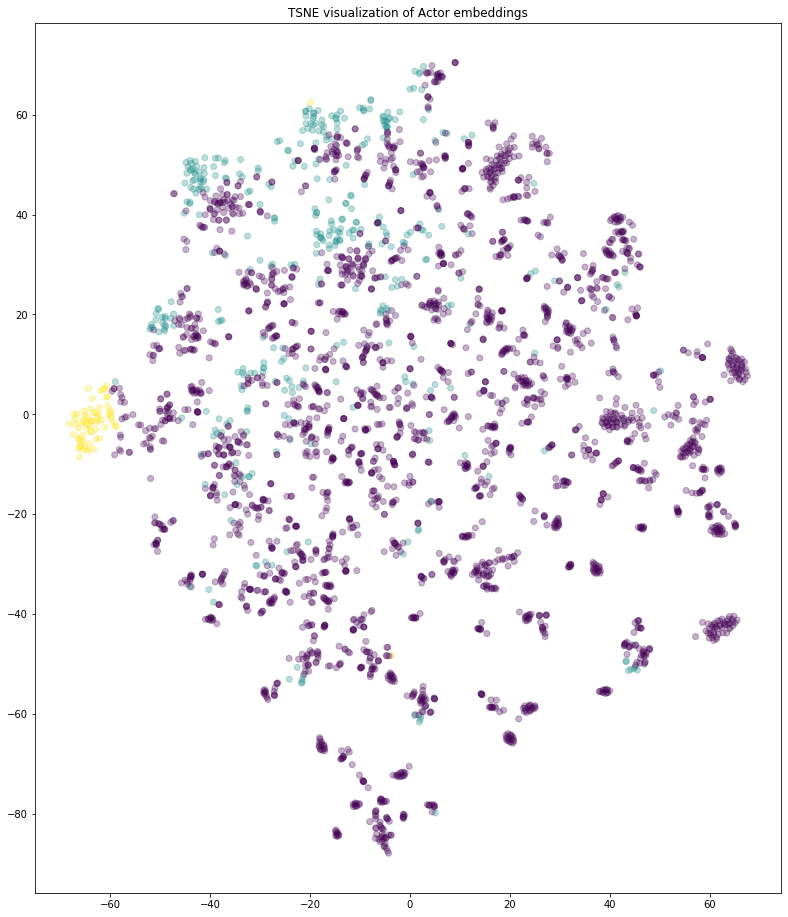

In [111]:
# draw the points

label_map = { l: i for i, l in enumerate(np.unique(actor_labels))}
node_colours = [ label_map[target] for target in actor_labels]

plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=node_colours, alpha=0.3)
plt.title('{} visualization of Actor embeddings'.format(transform.__name__))

plt.show()

###  2 : Apply clustering algorithm to group similar movies

In [112]:
clusters = [3, 5, 10, 30, 50, 100, 200, 500]
optimal_cluster = group_actors_movies(clusters, movie_embeddings, movie_nodes)

In [113]:
print(optimal_cluster)

3


<font color='blue'>Grouping similar movies</font>

In [114]:
movie_kmeans = KMeans(n_clusters=optimal_cluster).fit(movie_embeddings)
movie_labels = movie_kmeans.labels_
print(movie_labels)

[0 0 0 ... 1 1 1]


<font color='blue'>Displaying similar movie clusters</font>

In [115]:
transform = TSNE #PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(movie_embeddings)

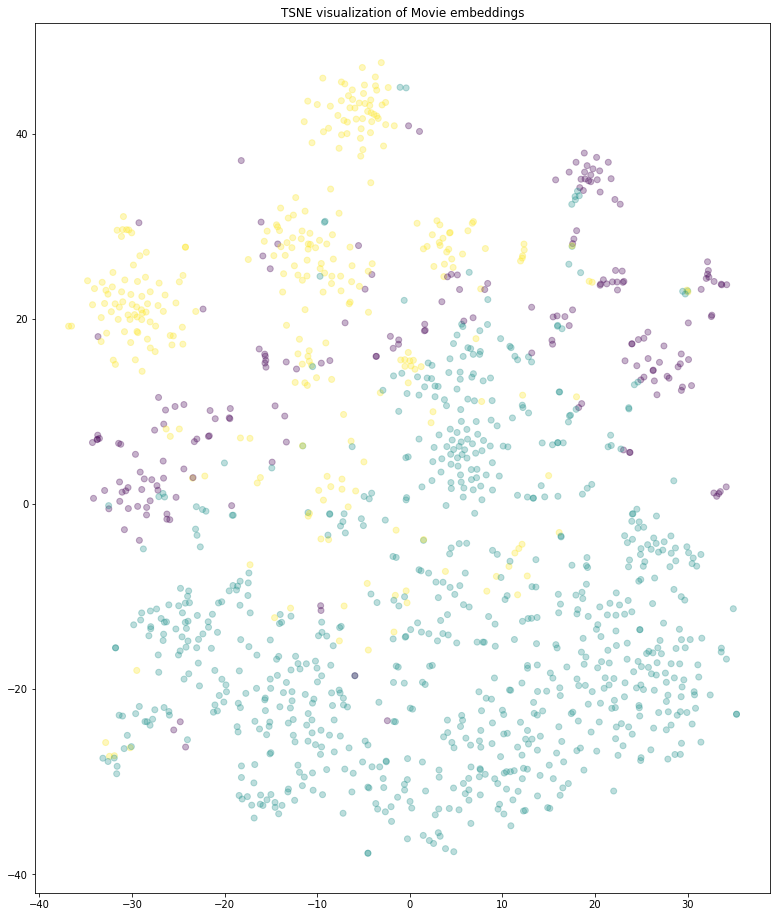

In [117]:
# draw the points

label_map = { l: i for i, l in enumerate(np.unique(movie_labels))}
node_colours = [ label_map[target] for target in movie_labels]

plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=node_colours, alpha=0.3)
plt.title('{} visualization of Movie embeddings'.format(transform.__name__))

plt.show()